# Initial ground truth generation

In order to train the model we require a ground truth peak set from which we can generate noisy waveforms. To create waveforms as similar to muscle contractions we use the partial differential model of muscle contraction presented here ().

First we must define the equations and describe a set of default parameters.

Without pertubation these equations will remain at rest, however we can model a stimulus by changing the value $k$ for a given period. This causes $CAsr$ to rise and the effect cascades through the equations to generate force. The function `pulse_train` can be used to generate values for $k$ which mimic an electrical pulse input in the system

In [1]:
#%%
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#%%
F = 0               # force generated (mN)
Fm = 1              # peak theroretical force (mN)
T1 = 49             # time constant for elastic relaxation (ms) default-49
T2 = 720            # time constant for relaxation with active contractile apparatus (ms) default-720
Ta = 4e-13          # conc of activated tropomyosin (M)
To = 10.22e-6       # total tropomyosin (M)
A = 0.009e5         # constant related to time constant of force increase (ms-1)
k = 0               # has a non-zero value k' for 4ms post action potential
k0 = 1e-1           # Ca uptake rate into SR (ms-1)
k1 = 1.43e9         # forward rate of tropomyosin Ca binding (M-2ms-1)
k2 = 0.036          # backward rate of tropomyosin Ca binding (ms-1)
CAsp = 1e-9         # Cytoplasmic Ca (M)
CAsr = 0.001        # SR Ca (M)


def force_differential(F,Fm,T1,T2,Ta,To,A):
    return A*Ta*(1-(F/Fm))-F/(T1+T2*(Ta/To))

def ca_differential(CAsp,CAsr,k1,k2,k0,k,Ta,To):
    return 2*(k1*CAsp**2 + k2)*Ta - 2*k1*To*CAsp**2 + k*CAsr - (k+k0)*CAsp

def tropomyosin_differential(k1,To,Ta,CAsp):
    return k1*To*CAsp**2 - (k1*CAsp**2 + k2)*Ta

def pulse_train(pulse_positions, pulse_length, time_series, k_prime):
    k_value = np.zeros(shape=time_series.shape)
    
    for p in pulse_positions:
        k_value[p:p+pulse_length] = k_prime        
        
    return k_value

We can now use these equations to produce contractile waveforms using micorsecond timesteps to predict changes is Cytoplasmic Ca which drives contraction through tropomyosin acivation of subusquent power stroke.

Initally we define the time period for the model, our base unit of time will be milliseconds (1e-3 s), the user should enter the desired model time period in ms on line 1 below

In [2]:
#%%
time_period = 2000

# convert time period to us and generate time axis for model
micro = 1e3
sample_rate = int(micro)
time_series = np.linspace(0,time_period,time_period*sample_rate+1)

We would like to generate a range of curves which can be used for training. These should differ in shape and type. To achieve this we will manipulate key paramters of the model one by one generating different model outcomes.

T1 = Time constant for elastic relaxation. This influences the second phase of relaxtion, larger values generate slower relaxations

k0 = Ca uptake rate into SR (ms-1). This affects strongly the first phase of relaxation broadening the top of the peak

k_value = Pulse train definition. By introducing additional non-zero values for $k$ we can cause effects like unfused and fused tetanus creating a range of unusual peak shapes

The user can define a range for each of these variables through which the model will cycle in all possible combinations.

In [3]:
# user defined variable search space
T1s = np.linspace(20,400,10)
k0s = np.linspace(1e-1,1e-2,1)
k_value = {
    '1Hz': pulse_train([i*sample_rate for i in [200]], 
                      4*sample_rate, 
                      time_series, 
                      1)
}

# count permutations generated by the user for future reference
total_models = len([i for i in itertools.product(T1s, k0s, k_value)])

# initialise dicts to hold model outcomes
force = {}
troponin = {}
calcium = {}

# for all values in the user defined space
for _T1, _k0, _k_val in itertools.product(T1s, k0s, k_value):

    # each individial model populates growing list
    trop = []
    cal = []
    newtons = []

    # for every time step in the model, note we loop through the k_value list as well as time
    for t,k_prime in zip(time_series,k_value[_k_val]):
            
        # adjust CAsp for given time step
        CAsp = CAsp + ca_differential(CAsp,CAsr,k1,k2,_k0,k_prime,Ta,To)/sample_rate
        
        # calculate activated tropomyosin from asjusted CAsp
        Ta = Ta + tropomyosin_differential(k1,To,Ta,CAsp)/sample_rate
        
        # force output from these variable
        F = F + force_differential(F,Fm,_T1,T2,Ta,To,A)/sample_rate

        # add timestep value to growing list
        trop.append(Ta)
        cal.append(CAsp)
        newtons.append(F)

    # add complete timeseries to sim dict
    force[_T1,_k0,_k_val] = newtons
    troponin[_T1,_k0,_k_val] = trop
    calcium[_T1,_k0,_k_val] = cal

    # print progress
    print(f'Simulating T1 = {_T1}, k0 = {_k0}, Pulse Train = {_k_val}')

Simulating T1 = 20.0, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 62.22222222222222, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 104.44444444444444, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 146.66666666666666, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 188.88888888888889, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 231.11111111111111, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 273.3333333333333, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 315.55555555555554, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 357.77777777777777, k0 = 0.1, Pulse Train = 1Hz
Simulating T1 = 400.0, k0 = 0.1, Pulse Train = 1Hz


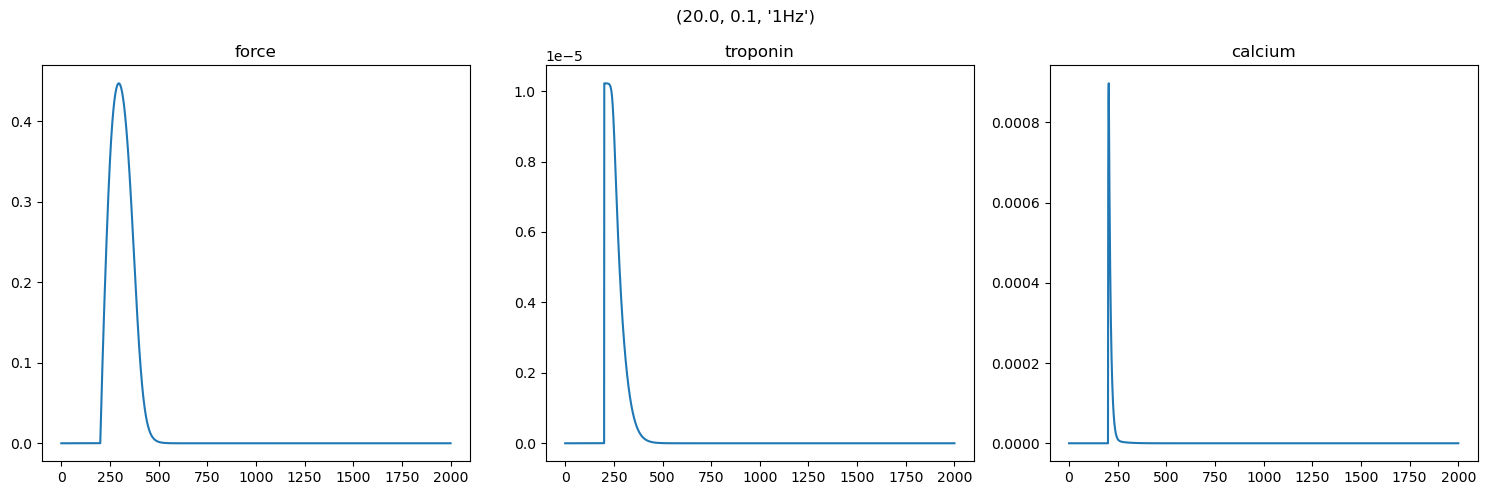

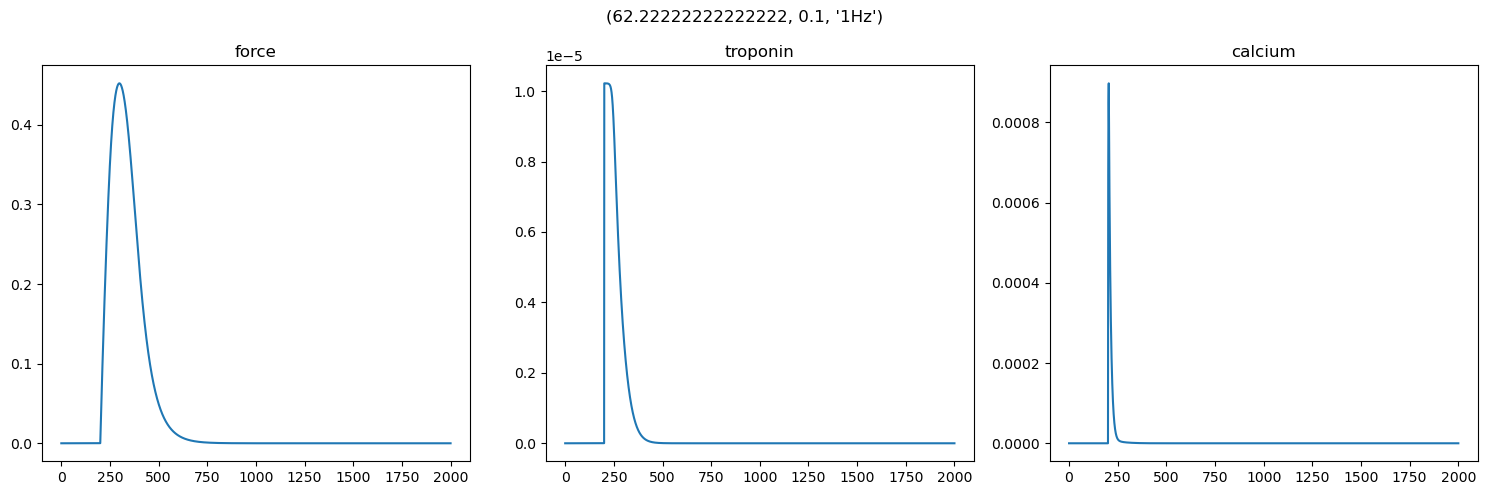

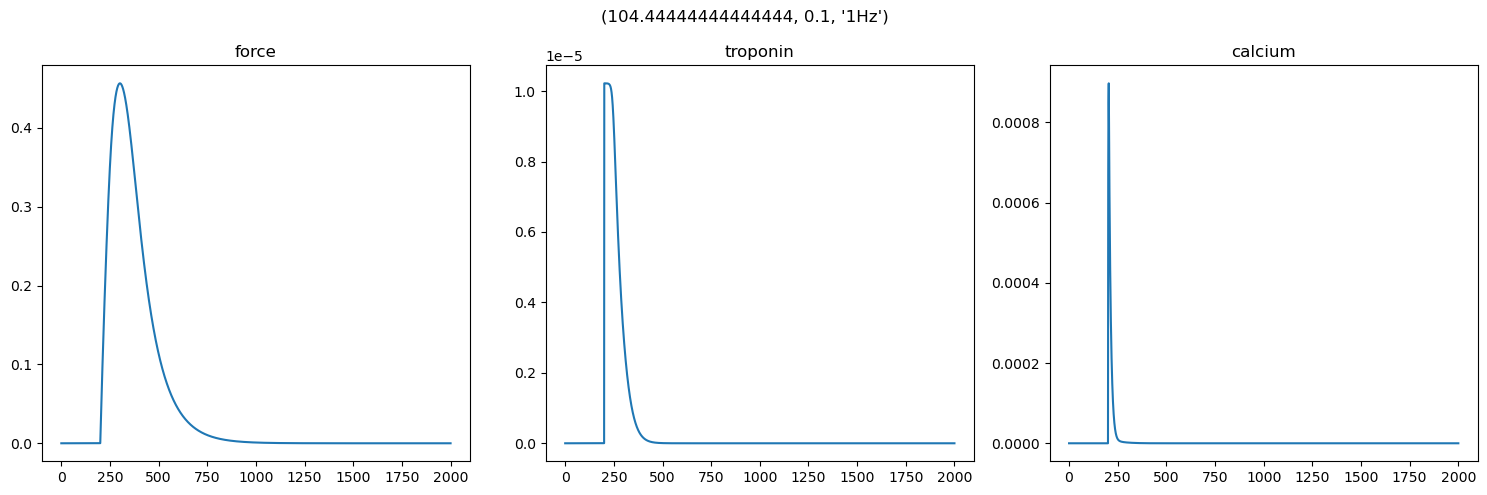

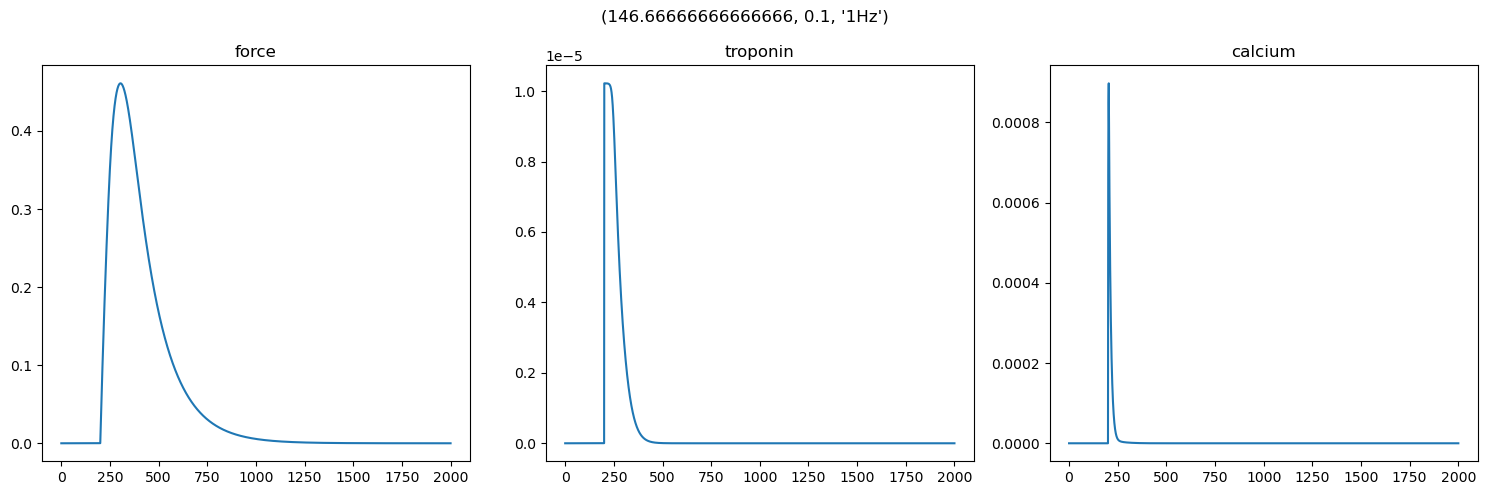

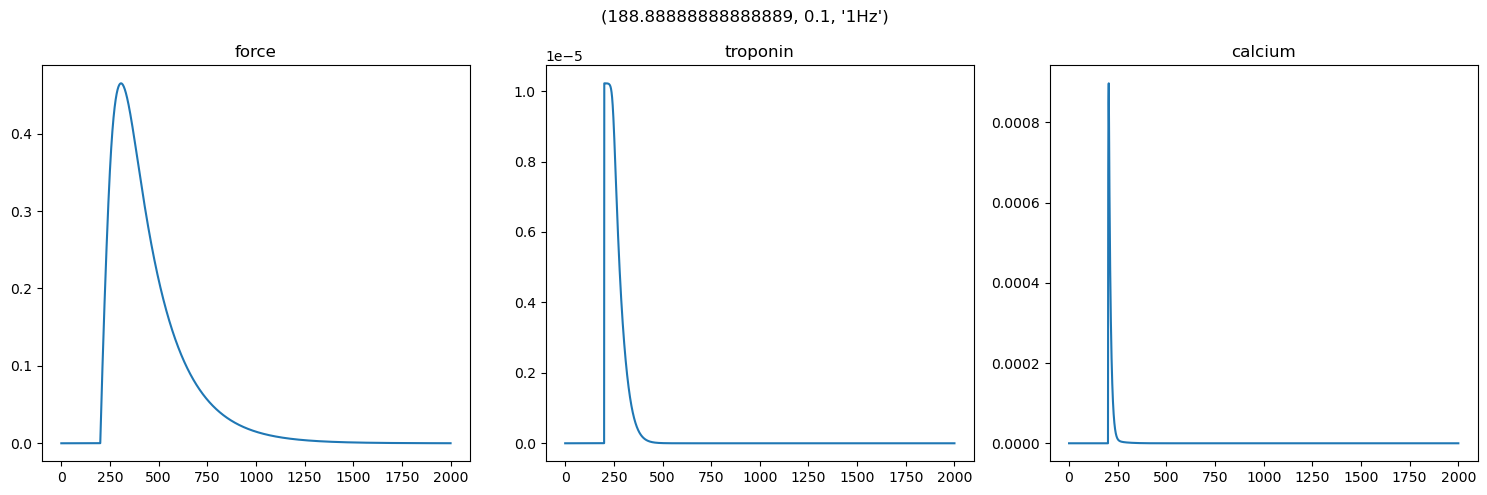

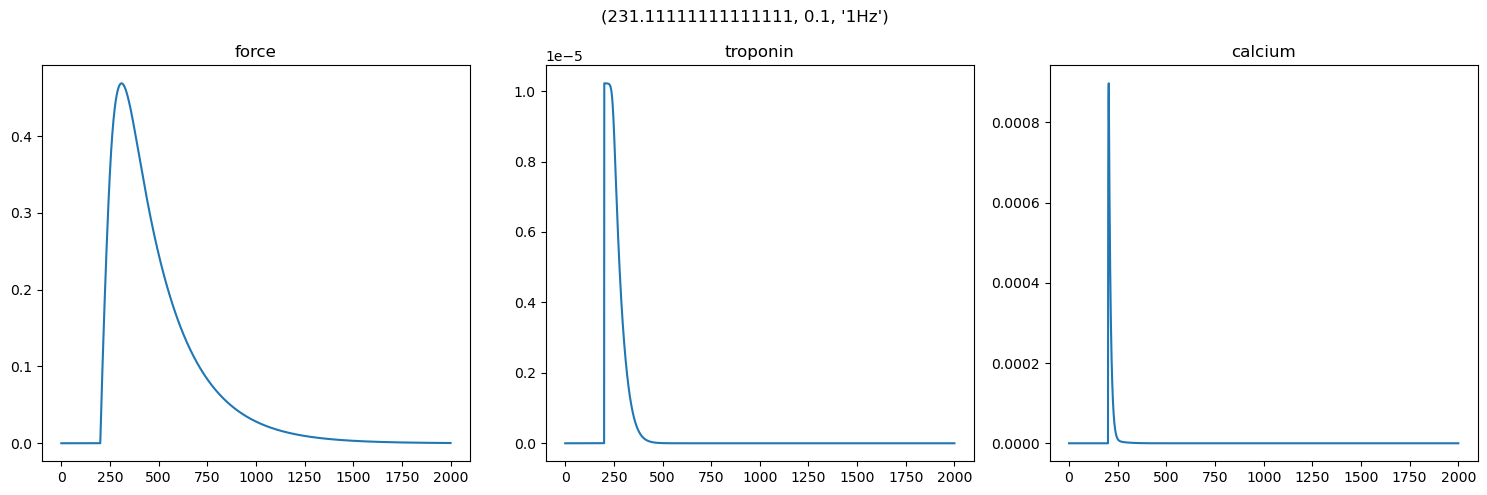

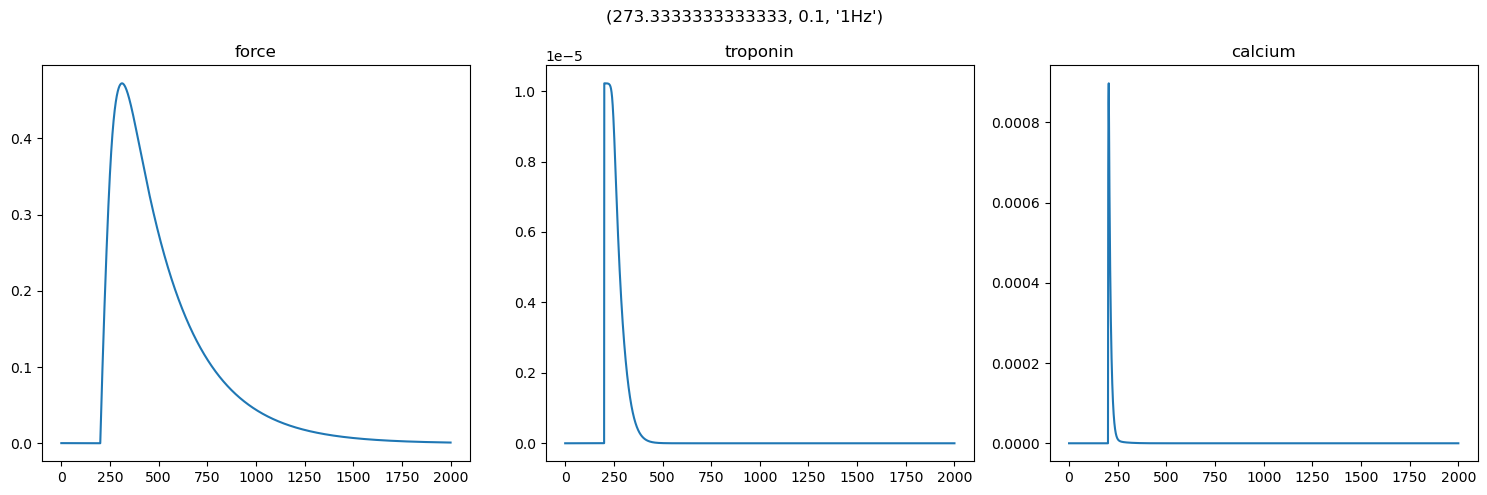

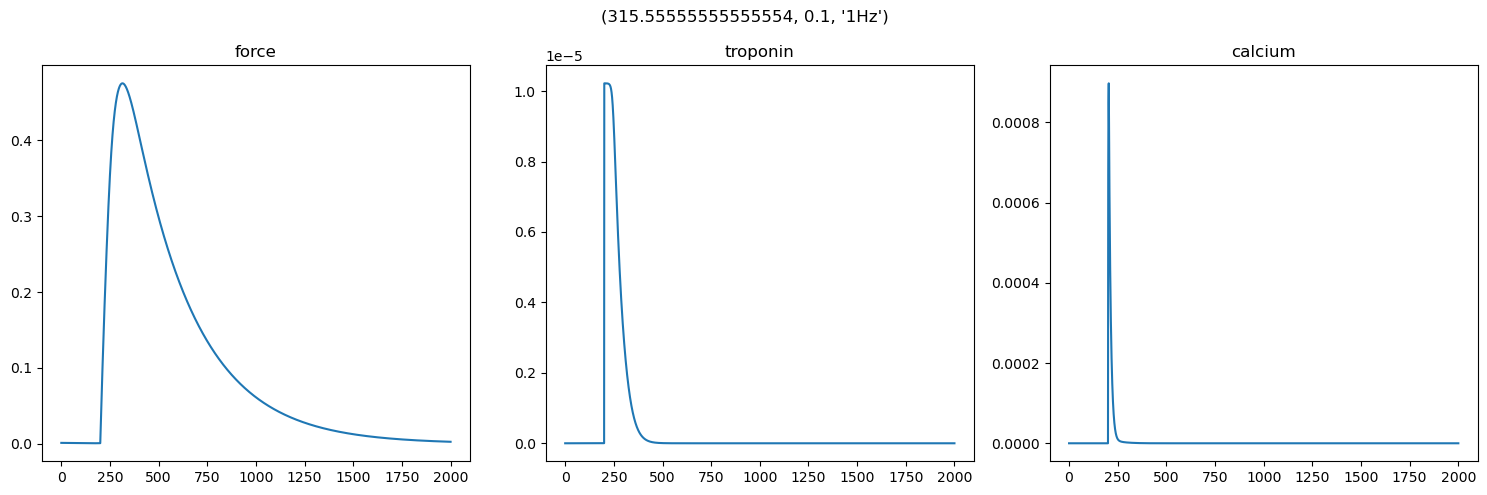

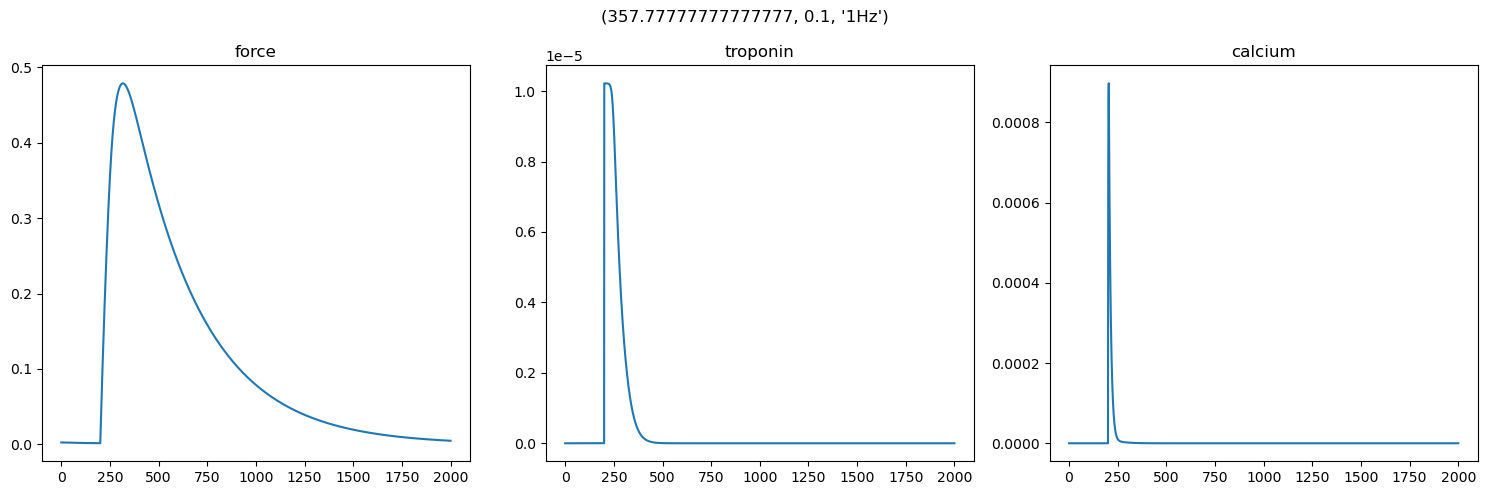

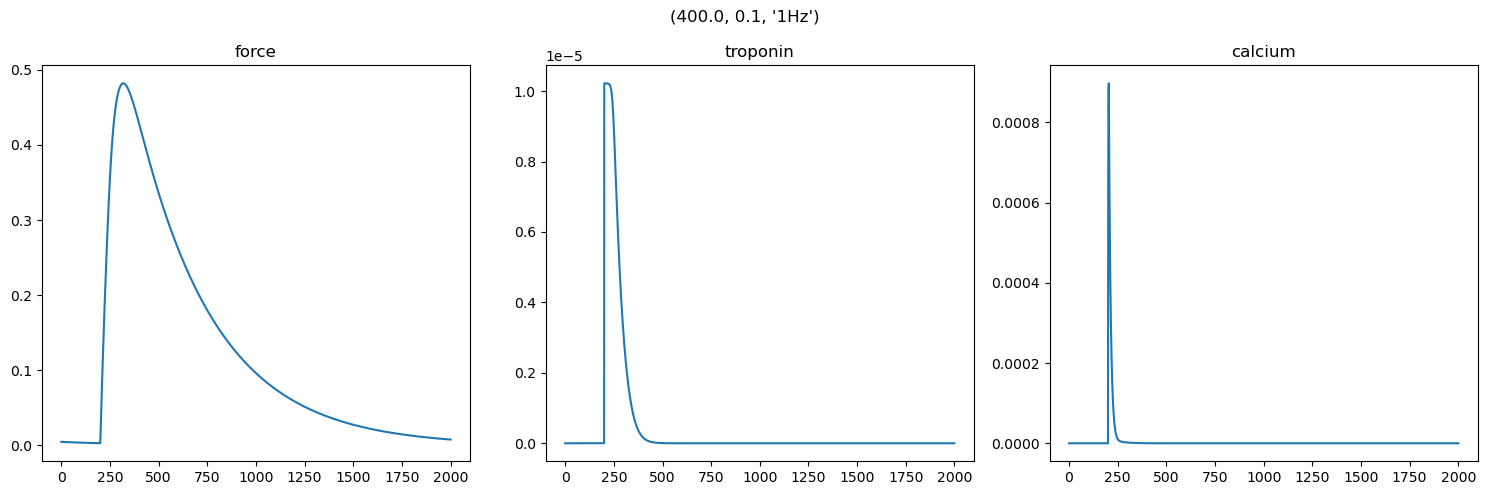

In [4]:
#%% plot all model peaks generated by simulations 
for key in force:
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].plot(time_series,force[key])
    axs[0].set_title('force')
    
    axs[1].plot(time_series,troponin[key])
    axs[1].set_title('troponin')
    
    axs[2].plot(time_series,calcium[key])
    axs[2].set_title('calcium')

    plt.suptitle(key)
    fig.tight_layout()
    plt.show()

# Modelled peak concatenation and noising

To generate a training set we now need to noise our waveforms and for ease for future manipulations we will also concatenate them into a single 1-D array which can be sliced as required later.

The user defines the number of duplicates (same ground truth peak + random noise) required and the target sample rate which the signal should be subsampled to. Eg a user may want to simulate data at $100Hz$ and create 20 recordings of this data in a noisy environment. For this the user would define `duplicates = 20, target_rate = 100`

Additionally we scale the ground truth peaks to generate peaks with different signal-to-noise ratios (SNR). The cell below takes every modelled waveform from above and scales it 1-10 in 1 step increments. 

Therefore this process produces $N*10*duplicate$ wavforms where $N = Total\ number\ of\ modelled\ peaks$

Finally the waveforms are shuffled to prevent any regular patterns emerging in the training set

In [5]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#%% duplicate and scale to produce different curves for training
duplcates = 100
target_rate = 100

# full rate is in Hz and model time step is us giving 1e6
full_rate = 1e6
slice_rate = int(full_rate/target_rate)
scales = np.tile(np.arange(1,11,1).reshape((10,1)), (duplcates, 1))

# subsample at target rate
force_subsample = {str(key):np.array(value[::slice_rate])
                       for key, value in force.items()}

# duplicate to allow scaling
force_subsample = {key:np.tile(value, (duplcates*10,1))
                       for key, value in force_subsample.items()}

# scale force values to give multiple peak heights
force_subsample = {key:value*scales 
                   for key, value in force_subsample.items()}

#%% add noise to scaled waveforms
noised_waveforms = {key:value+np.random.default_rng().normal(0, 0.1, value.shape)
                    for key, value in force_subsample.items()}

#%% concat into one array
Y = np.concatenate([v for v in noised_waveforms.values()])
X = np.concatenate([v for v in force_subsample.values()])

# shuffle array order before flattening to prevent regular sequences in the waveform
order = np.arange(Y.shape[0]).tolist()
random.shuffle(order)

Y = Y.take(order, axis=0).flatten()
X = X.take(order, axis=0).flatten()

#%% save training data
training_waveforms = np.array([X,Y])

We can plot the first 10 seconds of this simulated data to demonstrate to the user an example region of the training data

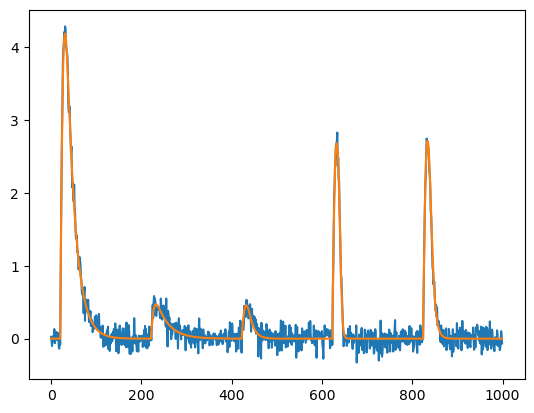

In [6]:
#%% plot to check data
plt.plot(Y[:1000])
plt.plot(X[:1000])

# Model fitting

We can now train our model, model configurations can be input by the user here

In [7]:
import math
import tensorflow.keras

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.constraints import max_norm

# Model configuration
batch_size = 50
no_epochs = 30
train_test_split = 0.3
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0
input_shape = (1+int(target_rate*time_period/1000), 1)

The data is split back into individual peaks, note that this means the input shape is the same as the origianlly defined time period at the sample rate used to subsample the data.

It may be worth considering different input shapes to optimise the training process.

Once divided into segments these are normalised to make the maximum value of any given segment 1 and minimum value 0

In [8]:
# Load data
total_waveforms = 10 * duplcates * total_models
time = np.arange(training_waveforms[1].shape[0]).reshape(total_waveforms,-1)
x_val_noisy, y_val_noisy = time ,training_waveforms[1].reshape(total_waveforms,-1)
x_val_pure, y_val_pure = time, training_waveforms[0].reshape(total_waveforms,-1)

#%%
# Reshape data
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
  noisy_sample = y_val_noisy[i]
  pure_sample = y_val_pure[i]
  noisy_sample = (noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample))
  pure_sample = (pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample))
  y_val_noisy_r.append(noisy_sample)
  y_val_pure_r.append(pure_sample)
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))

We can then split the waveform set into test and train sets as defined in the model params

In [9]:
#%%
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

The model is then defined and trained using the training inputs

In [10]:
#%%
kernel_sz = 15 # default 3
# Create the model
model = Sequential()

model.add(Conv1D(128, kernel_size=kernel_sz, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(64, kernel_size=kernel_sz, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=kernel_sz, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(128, kernel_size=kernel_sz, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=kernel_sz, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

model.summary()

#%%
# Compile and fit data
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 128)          2048      
                                                                 
 conv1d_1 (Conv1D)           (None, 173, 64)           122944    
                                                                 
 conv1d_transpose (Conv1DTra  (None, 187, 64)          61504     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 201, 128)         123008    
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, 201, 1)            1921      
                                                                 
Total params: 311,425
Trainable params: 311,425
Non-trai

Below we use the trained model to generate 5 predicted waveforms from the noisy test data and compare it with the ground truth pair graphically.

Note the need to scale outputs correctly, shape appears to be well matched and so it is a simple linear fit to scale the peak and re-baseline. Currently the fit is 
$y = mx + c$
but may be improved by fitting the equation
$y = mx + m*x.min()$ where $y$ is the noised waveform and x is the reconstruction

A process for assessing quatitatively the process needs to be developed

1/1 [==============================] - 0s 32ms/step


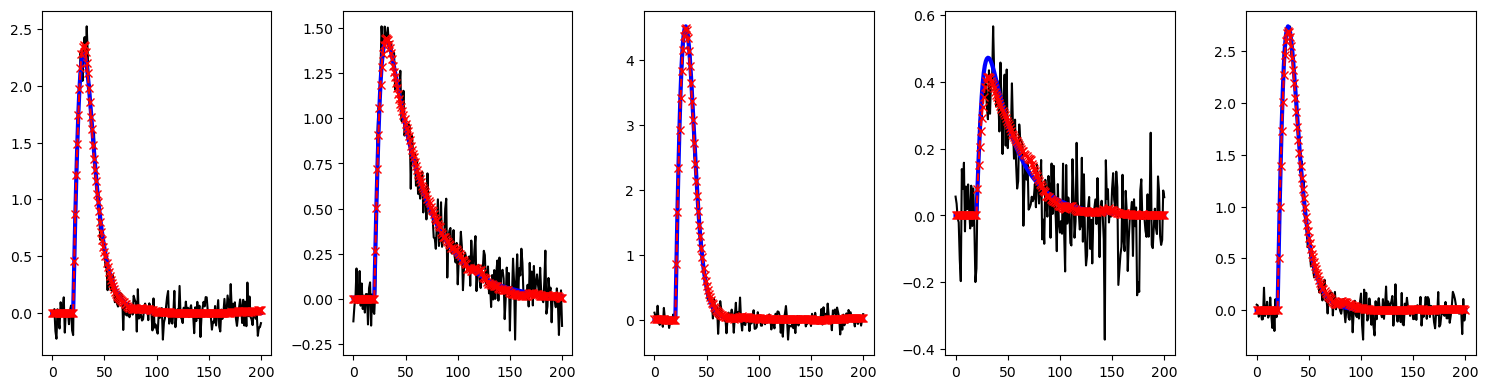

In [13]:
# Generate reconstructions
num_reconstructions = 5
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)

fig, axs = plt.subplots(1,num_reconstructions, figsize=(15,4),
                        sharex=True)

for i, ax in enumerate(axs):
    # Prediction index
    prediction_index = i + percentage_training
    # Get the sample and the reconstruction
    original = y_val_noisy[prediction_index]
    pure = y_val_pure[prediction_index]
    reconstruction = np.array(reconstructions[i])
    
    ax.plot(original, c='k')
    ax.plot(pure, c='b', linewidth=3)

    # peaks need to be rescaled, this is simply a scaling factor and baseline adjument so it a simple linear fit
    positivies = np.where(np.sort(original) > 0)[0][0]
    
    scaling = np.polyfit(np.sort(original)[positivies:], 
                         np.sort(reconstruction.squeeze())[positivies:],
                         1)
    
    ax.plot(reconstruction/scaling[0], 
            c='r',
            linestyle='--',
            marker='x')
    
plt.tight_layout()